# General aspects

```{note}
- [ ] Add relaxation discussion
- [ ] Clean up
- [ ] Can calculate SIE...?
- [ ] SO-coupling discussion...?
- [ ] Core-hole localization...?
- [ ] Tailored CVS space...?
- [ ] Discuss basis set results
```

Discussing some special topics.

*Loading functionalities:*

In [6]:
# loading modules etc

# standard Python modules and functions
from scipy.interpolate import interp1d
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import copy

# QC software suites and functionalities
from pyscf import gto, scf, mp, cc
import veloxchem as vlx
import gator
import adcc
from veloxchem.rsplinabscross import LinearAbsorptionCrossSection

# for vlx
silent_ostream = vlx.OutputStream(None)
from mpi4py import MPI
comm = MPI.COMM_WORLD

# au to eV conversion factor
au2ev = 27.211386

(sec:xray_topics_relax)=
## Relaxation

1. Radial distribution: Z, Z with hole, Z+1

2. Total density: formaldehyde

3. Maybe: visualization of effects for XAS and XES


```{figure} ../img/xray/relax_form.svg
---
name: relax_form
---
foo
```

```{figure} ../img/xray/relax_processes.svg
---
name: relax_processes
---
foo
```


### Including with $\Delta\textrm{SCF}$ methods

```{note}
Illustrative calculations.
```

### Including for wave function methods

```{note}
Maybe relaxation versus v2, or so.
```


### Including for DFT-based methods

```{note}
Not sure anything can really be said.
```

(sec:xray_topics_rel)=
## Relativity

Total relativistic and correlation corrections as a function of Z

Note: not additive with correlation


### Scalar relativistic effects


(sec:xray_topics_rel_ip)=
#### For ionization potentials

In [9]:
z, rel_mo, rel_delta, rel_e = [],[],[],[]
for i in np.arange(2,20,2):
    struct = str(i)+'   0.0  0.0  0.0'
    mol = gto.Mole(); mol.atom  = struct; mol.basis = 'unc-ccpvdz'; mol.build()
    scf_nr  = scf.UHF(mol); scf_nr.kernel()
    scf_rel = scf.UHF(mol).x2c1e(); scf_rel.kernel()
    z.append(i)
    rel_mo.append(27.2114*(scf_nr.mo_energy[0][0]-scf_rel.mo_energy[0][0]))
    mo0 = copy.deepcopy(scf_nr.mo_coeff); occ0 = copy.deepcopy(scf_nr.mo_occ); occ0[0][0] = 0.0
    ion_nr  = scf.UHF(mol); scf.addons.mom_occ(ion_nr, mo0, occ0);  ion_nr.kernel()
    ion_rel = scf.UHF(mol).x2c1e();     scf.addons.mom_occ(ion_rel, mo0, occ0);     ion_rel.kernel()
    rel_delta.append(27.2114*((ion_rel.e_tot-scf_rel.e_tot)-(ion_nr.e_tot-scf_nr.e_tot)))
    rel_e.append(27.2114*(ion_rel.e_tot-scf_rel.e_tot))

converged SCF energy = -2.85516047724517  <S^2> = 1.3322676e-15  2S+1 = 1
converged SCF energy = -2.85525304501235  <S^2> = 1.110223e-15  2S+1 = 1
converged SCF energy = -1.9942685861792  <S^2> = 0.75  2S+1 = 2


Overwritten attributes  get_occ  of <class 'pyscf.scf.uhf.UHF'>
Overwritten attributes  get_occ  of <class 'pyscf.x2c.sfx2c1e.sfx2c1e.<locals>.SFX2C1E_SCF'>


converged SCF energy = -1.99436880481848  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -14.5723376313363  <S^2> = 2.8865799e-15  2S+1 = 1
converged SCF energy = -14.5748455751041  <S^2> = 1.7763568e-15  2S+1 = 1
converged SCF energy = -10.0357274640245  <S^2> = 0.75629212  2S+1 = 2.0062823
converged SCF energy = -10.0378218682323  <S^2> = 0.75630468  2S+1 = 2.0062948
converged SCF energy = -37.596291563267  <S^2> = 1.7763568e-15  2S+1 = 1
converged SCF energy = -37.6112425609782  <S^2> = -8.8817842e-16  2S+1 = 1
converged SCF energy = -26.6586016324336  <S^2> = 0.75725115  2S+1 = 2.0072381
converged SCF energy = -26.6699783724091  <S^2> = 0.75726738  2S+1 = 2.0072542
converged SCF energy = -74.665428938125  <S^2> = 5.3290705e-15  2S+1 = 1
converged SCF energy = -74.7175020694568  <S^2> = 0  2S+1 = 1
converged SCF energy = -54.5945032394038  <S^2> = 0.75658425  2S+1 = 2.0065734
converged SCF energy = -54.632827234573  <S^2> = 0.75660276  2S+1 = 2.0065919
converged SCF energy = -128.488

yielding

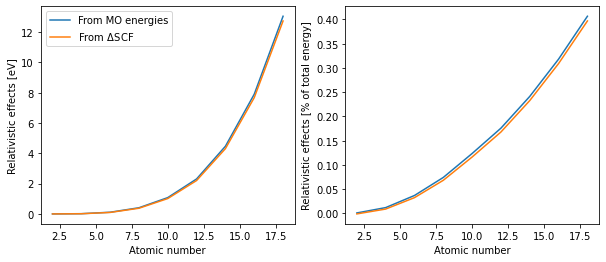

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(z,rel_mo)
plt.plot(z,rel_delta)
plt.legend(('From MO energies',r'From $\Delta$SCF'))
plt.xlabel('Atomic number')
plt.ylabel('Relativistic effects [eV]')
plt.subplot(122)
plt.plot(z,100*np.array(rel_mo)/np.array(rel_e))
plt.plot(z,100*np.array(rel_delta)/np.array(rel_e))
plt.xlabel('Atomic number')
plt.ylabel('Relativistic effects [% of total energy]')
plt.show()

#### For spectra (XAS)

In [11]:
mol = gto.Mole()
mol.atom  = water; mol.basis = 'unc-6-31G'
mol.build()

# non-relativistic
scf_nr  = scf.RHF(mol); scf_nr.kernel()
adc_nr  = adcc.cvs_adc2(scf_nr,n_singlets=5,core_orbitals=1)

# relativistic
scf_rel = scf.RHF(mol).x2c1e(); scf_rel.kernel()
adc_rel = adcc.cvs_adc2(scf_rel,n_singlets=5,core_orbitals=1)

converged SCF energy = -75.9890271783229


/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


Starting cvs-adc2 singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1    10        2.7777  582ms  [20.27588296 20.31155183 20.86140432 20.92171887 20.92996834]
  2    20      0.035824  557ms  [19.72872545 19.81092766 20.31040554 20.40470691 20.49837544]
  3    30    4.1402e-05  868ms  [19.72388013 19.80673445 20.3057139  20.39997868 20.49772007]
=== Converged ===
    Number of matrix applies:    30
    Total solver time:             2s  42ms
converged SCF energy = -76.0403950942124
Starting cvs-adc2 singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1    10        2.7842  680ms  [20.29049204 20.32651304 20.87612706 20.93658562 20.9451677 ]
  2    20      0.036027  663ms  [19.74278629 19.82524258 20.32473443 20.41889866 20.51251234]
  3    30    4.1677e-05  588ms  [19.73792472 19.82102908 20.32001931 20.41414446 20.51185242]
=== Converged ===
    Number of matrix applies:    30
    Total solver time:             1s 983ms


with results:

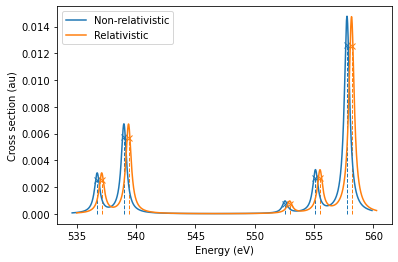

Energy shift of the first feature: 0.38 eV


In [12]:
plt.figure()
adc_nr.plot_spectrum(label='Non-relativistic')
adc_rel.plot_spectrum(label='Relativistic')
plt.legend(); plt.show()
print('Energy shift of the first feature:',
      np.around(au2ev*(adc_rel.excitation_energy[0]-adc_nr.excitation_energy[0]),2),'eV')

### Spin-orbit coupling

```{note}
Will not be able to illustrate for a while, but maybe insert short discussion.
```

(sec:xray_topics_basis)=
## Basis set considerations

The basis set requirements of X-ray spectrum calculations will depend strongly on which spectroscopy

- XPS and XES probes occupied states, and thus need a good description of those

- XAS and RIXS probes excited states, and thus need an improved description also of this region

However, in both cases the relaxation due to the creation of a core-hole need to be enabled, which yield requirements of reasonable flexibility of the core and inner valence region. This is not typically the case, as most studies deals with valence electron and thus have a minimal or close to minimal description of the core region.

A number of approaches for improving the basis sets have been developed:

1. Augment the Dunning basis sets with core-polarizing functions, e.g. cc-pV*n*Z $\rightarrow$ cc-pCV*n*Z

2. Adding extra flexibility by performing full or partial decontraction, e.g.
    1. u6-311++G\*\* is 6-311++G\*\* with decontracted 1s function of the probed element
    2. un-6-311++G\*\* is a fully decontracted 6-311++G\*\* basis set

3. Use basis functions from the next element, is inspired by the equvalent core/Z+1 approximation

Here we focus on the basis set effects for calculations of the IP of water, and we encourage the interested reader to do the same excercise for XES, as well as for XAS (where the augmentation of diffuse functions also need to be considered).

In [13]:
u6311gss  = {'O': gto.basis.parse('''
O    S
   8588.500                  1.000000 
O    S
   1297.230                  1.000000 
O    S
    299.2960                 1.000000 
O    S
     87.37710                1.000000 
O    S
     25.67890                1.000000 
O    S
      3.740040               1.000000 
O    SP
     42.11750                0.113889               0.0365114
      9.628370               0.920811               0.237153
      2.853320              -0.00327447             0.819702
O    SP
      0.905661               1.000000               1.000000
O    SP
      0.255611               1.000000               1.000000
O    D
      1.292                  1.000000
'''), 'H': '6-311G**'}
un6311gss = {'O': gto.basis.parse('''
O    S
   8588.500                  1.000000 
O    S
   1297.230                  1.000000 
O    S
    299.2960                 1.000000 
O    S
     87.37710                1.000000 
O    S
     25.67890                1.000000 
O    S
      3.740040               1.000000 
O    SP
     42.11750                1.000000               1.000000
O    SP
      9.628370               1.000000               1.000000
O    SP
      2.853320               1.000000               1.000000
O    SP
      0.905661               1.000000               1.000000
O    SP
      0.255611               1.000000               1.000000
O    D
      1.292                  1.000000
'''), 'H': '6-311G**'}
z6311gss  = {'O': gto.basis.parse('''
O    S
   8588.500                  0.00189515
   1297.230                  0.0143859
    299.2960                 0.0707320
     87.37710                0.2400010
     25.67890                0.5947970
      3.740040               0.2808020
O    SP
     42.11750                0.113889               0.0365114
      9.628370               0.920811               0.237153
      2.853320              -0.00327447             0.819702
O    SP
      0.905661               1.000000               1.000000
O    SP
      0.255611               1.000000               1.000000
O    D
      1.292                  1.000000
O    S
  11427.10                   0.00180093
   1722.350                  0.0137419
    395.7460                 0.0681334
    115.1390                 0.2333250
     33.60260                0.5890860
      4.919010               0.2995050
O    SP
     55.44410                0.114536               0.0354609
     12.63230                0.920512               0.237451
      3.717560              -0.00337804             0.820458
O    SP
      1.165450               1.000000               1.000000
O    SP
      0.321892               1.000000               1.000000
O    D
      1.750                  1.000000
'''), 'H': '6-311G**'}

Exotic version of basis sets found above

```python
basis_sets = ['6-311G**',u6311gss,un6311gss,z6311gss, 'cc-pVDZ', 'cc-pCVDZ', 'cc-pVTZ', 'cc-pCVTZ','cc-pVQZ', 'cc-pCVQZ']
ip_hf, ip_mp2, ip_ccsd, ip_b3lyp, n_bas = [],[],[],[],[]
for basis in basis_sets:
    mol = gto.Mole(); mol.atom  = water; mol.basis = basis
    mol.build()
    scfres = scf.UHF(mol); scfres.kernel()
    mo0 = copy.deepcopy(scfres.mo_coeff); occ0 = copy.deepcopy(scfres.mo_occ); occ0[0][0] = 0.0
    scfion = scf.UHF(mol); scf.addons.mom_occ(scfion, mo0, occ0); scfion.kernel()
    ip_hf.append(au2ev*(scfion.energy_tot() - scfres.energy_tot()))
    ccsd_res = cc.UCCSD(scfres).run(); ccsd_ion = cc.UCCSD(scfion).run(max_cycle=500)
    ip_ccsd.append(au2ev*(ccsd_ion.e_tot - ccsd_res.e_tot))
    ip_mp2.append(au2ev*(ccsd_ion.e_hf+ccsd_ion.emp2-(ccsd_res.e_hf+ccsd_res.emp2)))
    scfres = scf.UKS(mol); scfres.xc = 'b3lyp'; scfres.kernel()
    mo0 = copy.deepcopy(scfres.mo_coeff); occ0 = copy.deepcopy(scfres.mo_occ); occ0[0][0] = 0.0
    scfion = scf.UKS(mol); scf.addons.mom_occ(scfion, mo0, occ0); scfion.xc = 'b3lyp'; scfion.kernel()
    ip_b3lyp.append(au2ev*(scfion.energy_tot() - scfres.energy_tot()))
    n_bas.append(len(scfres.mo_occ[0]))
    
plt.figure(figsize=(10,5))
basis_set_labels = ['6-311G**','u6-311G**','un6-311G**','6-311G** (Z+1)', 'cc-pVDZ', 'cc-pCVDZ', 'cc-pVTZ', 'cc-pCVTZ','cc-pVQZ', 'cc-pCVQZ']
plt.plot(n_bas,ip_hf,'r*'); plt.plot(n_bas,ip_mp2,'bv')
plt.plot(n_bas,ip_ccsd,'d',color='orange'); plt.plot(n_bas,ip_b3lyp,'go')
plt.plot([min(n_bas)-5,max(n_bas)+5],[539.9,539.9],'k:')
plt.plot([min(n_bas)-5,max(n_bas)+5],[539.9-0.3,539.9-0.3],'k--')
plt.xlim((min(n_bas)-5,max(n_bas)+5))
plt.ylabel('Ionization potential [eV]')
plt.legend(('HF','MP2','CCSD','B3LYP','Expt','Expt - 0.3 eV'))
plt.xticks(n_bas,basis_set_labels,rotation=70,fontsize=10)
plt.tight_layout(); plt.savefig('basis_xps.svg')
plt.show()
```

The execution of which yields



```{figure} ../img/xray/basis_xps.svg
---
name: basis_xps
---
foo
```

On the y-axis we see the basis set labels, with order and position determined by the number of basis functions.

We see that...

(sec:xray_topics_sie)=
## Self-interaction error in DFT

For a single-electron systems the following equality should hold for the two-electron terms:

$$
J[\rho] + E_{xc} [\rho] = 0.0
$$

This cancellation is achieved for, e.g. Hartree–Fock theory, but for any approximate functionals in DFT it will instead result in an erronous contribution to the energy. DFT-based methods generally suffer from self-interaction error (SIE), which corresponds to the sum of Coulomb and exchange self-interactions that remain because of the use of approximate exchange functionals. In more detail, the Coulomb self-repulsion of each electron included in the Coulomb operator is exactly canceled by the nonlocal exchange self-attraction in Hartree--Fock theory, but this is no longer the case when the exchange operator is replaced by an approximate exchange functional.

Consider the ionization potential of water, as calculated with MO energy and $\Delta\textrm{SCF}$. Former a reasonable representative of IP from TDDFT XAS calculation.

In [7]:
water = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# Prepare molecule object
mol       = gto.Mole(); mol.atom  = water; mol.basis = '6-31G'; mol.build()

# HF exchange and creating result containers
hf_exc  = [0.0,0.25,0.50,0.75,1.0]
hf_blyp,hf_pbe = [[],[]], [[],[]]

for h_x in hf_exc:
    ###### BxLYP (Slater exchange 0.08, except when HF i 1.00)
    if h_x == 1.0: s_x = 0.00
    else:          s_x = 0.08 
    b_x      = 1.00 - h_x - s_x
    v_e, v_l = 0.19, 0.81
    # Neutral calculation
    dft_res    = scf.UKS(mol)
    dft_res.xc = f'{h_x:} * HF + {s_x:} * Slater + {b_x:} * B88, {v_l:} * LYP + {v_e:} * VWN'
    dft_res.kernel()
    # Core-hole calculation
    mo0  = copy.deepcopy(dft_res.mo_coeff); occ0 = copy.deepcopy(dft_res.mo_occ); occ0[0][0] = 0.0; dft_ion = scf.UKS(mol)
    dft_ion.xc = f'{h_x:} * HF + {s_x:} * Slater + {b_x:} * B88, {v_l:} * LYP + {v_e:} * VWN'
    scf.addons.mom_occ(dft_ion, mo0, occ0); dft_ion.kernel()
    # Extract results
    hf_blyp[0].append(au2ev*(dft_ion.energy_tot() - dft_res.energy_tot()))
    hf_blyp[1].append(-au2ev*dft_res.mo_energy[0][0])
    
    ###### PBEx
    p_x = 1.0 - h_x
    # Neutral calculation
    dft_res    = scf.UKS(mol)
    dft_res.xc = f'{h_x:} * HF + {p_x:} * PBE, PBE'
    dft_res.kernel()
    # Core-hole calculation
    mo0  = copy.deepcopy(dft_res.mo_coeff); occ0 = copy.deepcopy(dft_res.mo_occ);  occ0[0][0] = 0.0; dft_ion = scf.UKS(mol)
    dft_ion.xc = f'{h_x:} * HF + {p_x:} * PBE, PBE'
    scf.addons.mom_occ(dft_ion, mo0, occ0); dft_ion.kernel()
    # Extract results
    hf_pbe[0].append(au2ev*(dft_ion.energy_tot() - dft_res.energy_tot()))
    hf_pbe[1].append(-au2ev*dft_res.mo_energy[0][0])

converged SCF energy = -76.3570352138422  <S^2> = 9.8854258e-13  2S+1 = 1
converged SCF energy = -56.4237670553342  <S^2> = 0.75372494  2S+1 = 2.0037215
converged SCF energy = -76.2984404502068  <S^2> = 6.9455552e-13  2S+1 = 1
converged SCF energy = -56.3921764305246  <S^2> = 0.75419443  2S+1 = 2.00419
converged SCF energy = -76.3458605029086  <S^2> = 1.9795721e-11  2S+1 = 1
converged SCF energy = -56.4097695592283  <S^2> = 0.75459735  2S+1 = 2.0045921
converged SCF energy = -76.3012084721053  <S^2> = 3.3200109e-12  2S+1 = 1
converged SCF energy = -56.3896010586894  <S^2> = 0.7552122  2S+1 = 2.0052054
converged SCF energy = -76.3352647255064  <S^2> = 1.3756107e-11  2S+1 = 1
converged SCF energy = -56.3960927713703  <S^2> = 0.7556359  2S+1 = 2.005628
converged SCF energy = -76.3045772524469  <S^2> = 2.934808e-11  2S+1 = 1
converged SCF energy = -56.3873473076527  <S^2> = 0.75643162  2S+1 = 2.0064213
converged SCF energy = -76.3251998349411  <S^2> = 1.0945023e-11  2S+1 = 1
converged SCF 

With results:

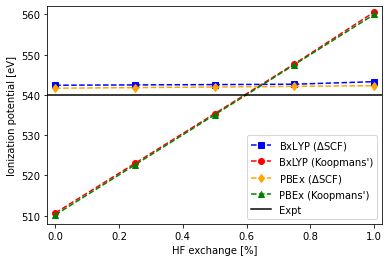

In [8]:
plt.figure(figsize=(6,4))
plt.plot(hf_exc,hf_blyp[0],'bs--')
plt.plot(hf_exc,hf_blyp[1],'ro--')
plt.plot(hf_exc,hf_pbe[0],'d--',color='orange')
plt.plot(hf_exc,hf_pbe[1],'g^--')
plt.plot([-0.1,1.1],[539.9,539.9],'k-')
plt.legend((r'BxLYP ($\Delta$SCF)','BxLYP (Koopmans\')',r'PBEx ($\Delta$SCF)','PBEx (Koopmans\')','Expt'))
plt.xlim((-0.025,1.025)); plt.ylim((508,562.))
plt.xlabel('HF exchange [%]')
plt.ylabel('Ionization potential [eV]')
plt.show()

As can be seen, the IP error from MO energies (which scales as the XAS error) does not appreciably depend on the functional, save for HF exchange.

- Radial distribution for functionals?

- Calculate SIE?


(sec:xray_topics_chloc)=
## Core-hole localization

- Compare "physical reality" and practical calculations

- Discuss localization for IP and XES
    - Example: ethene

- Might mention XAS with, e.g., STEX and TP-DFT as well


(sec:xray_topics_tailcvs)=
## Tailored CVS

- Tie to discussion of core-hole localization as found above

- Focus on ADC
    - Example: ethene